In [604]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt



In [605]:
df = pd.read_csv('data_science_competition_2024.csv')
df.head()


,Unnamed: 0,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,female,2022 10 29,USD,Zimbabwe,female,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,1,368bf756-fcf2-4822-9612-f445d90b485b,other,2020 06 06,USD,Zimbabwe,other,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,2,6e3be39e-49b5-45b5-aab6-c6556de53c6f,other,2023 09 29,USD,Zimbabwe,other,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,3,191c62f8-2211-49fe-ba91-43556b307871,female,2022 06 22,USD,Zimbabwe,female,True,Doctor,Rusape,24000.0,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default
4,4,477cd8a1-3b01-4623-9318-8cd6122a8346,male,2023 02 08,USD,Zimbabwe,male,True,Nurse,Chipinge,19000.0,0,34156.055882,0.20,42,0,45,2310.858441,married,42,Did not default


In [606]:

df.drop(['Unnamed: 0', 'loan_id'], axis=1, inplace=True)

In [607]:
df.shape

(100000, 19)

In [608]:
df.value_counts()

gender  disbursemet_date  currency  country   sex     is_employed  job                 location  loan_amount  number_of_defaults  outstanding_balance  interest_rate  age  number_of_defaults.1  remaining term  salary       marital_status  age.1  Loan Status    
female  2020 01 01        USD       Zimbabwe  female  True         Accountant          Chipinge  11000.0      1                   27707.282179         0.20           52   1                     57              2167.382256  single          52     Did not default    1
male    2023 11 15        USD       Zimbabwe  male    True         Engineer            Bulawayo  20000.0      0                   32870.547675         0.21           44   0                     54              2463.843177  married         44     Did not default    1
                                                                   Nurse               Karoi     24000.0      0                   39885.927140         0.20           47   0                     49            

In [609]:
df.isna().sum()

gender                     0
disbursemet_date           0
currency                   0
country                  100
sex                        0
is_employed                0
job                     4136
location                 595
loan_amount                0
number_of_defaults         0
outstanding_balance        0
interest_rate              0
age                        0
number_of_defaults.1       0
remaining term             0
salary                     0
marital_status             0
age.1                      0
Loan Status                0
dtype: int64

In [610]:
df.country.value_counts()

country
Zimbabwe    99787
zimbabwe      100
Zim            13
Name: count, dtype: int64

In [611]:
# function to correct spelling
def consistent_column_spelling(column, current_label, correctlabel):
    df.loc[df[column]== current_label, column] = correctlabel

In [612]:
# make the country columns consistent by setting them to zimbabwe
consistent_column_spelling('country', 'Zimbabwe', 'zimbabwe')
consistent_column_spelling('country', 'Zim', 'zimbabwe')
df.country.value_counts()

country
zimbabwe    99900
Name: count, dtype: int64

In [613]:
df.dtypes

gender                   object
disbursemet_date         object
currency                 object
country                  object
sex                      object
is_employed                bool
job                      object
location                 object
loan_amount             float64
number_of_defaults        int64
outstanding_balance     float64
interest_rate           float64
age                       int64
number_of_defaults.1      int64
remaining term           object
salary                  float64
marital_status           object
age.1                     int64
Loan Status              object
dtype: object

In [614]:
df.job.value_counts()




job
Engineer              16524
Nurse                 15284
Data Analyst          13204
Doctor                12186
Software Developer    11932
Teacher                8950
Accountant             7802
SoftwareDeveloper      3564
Data Scientist         3521
Lawyer                 2862
Data Scintist            35
Name: count, dtype: int64

In [615]:
# consistent spelling value for job column
consistent_column_spelling('job', 'Data Scintist', 'Data Scientist')
consistent_column_spelling('job', 'SoftwareDeveloper', 'Software Developer')
df.job.value_counts()

job
Engineer              16524
Software Developer    15496
Nurse                 15284
Data Analyst          13204
Doctor                12186
Teacher                8950
Accountant             7802
Data Scientist         3556
Lawyer                 2862
Name: count, dtype: int64

In [616]:
df.gender.value_counts()

gender
male      35028
female    32685
other     32287
Name: count, dtype: int64

In [617]:
df.currency.value_counts()

currency
USD     99980
$USD       20
Name: count, dtype: int64

In [618]:
consistent_column_spelling('currency', '$USD', 'USD')

In [619]:
pd.set_option('display.max_columns', None)
print(df.location.value_counts().to_string())

location
Harare                8338
Bulawayo              8078
Mutare                8062
Gweru                 7803
Masvingo              7476
Marondera             7343
Rusape                6378
Chivhu                6257
Plumtree              5431
Beitbridge            5181
Chipinge              4358
Chimanimani           4296
Kwekwe                3401
Chiredzi              3123
Kadoma                3049
Nyanga                2099
Karoi                 1850
Shurugwi              1322
Zvishavane            1276
Gokwe                  901
Kariba                 652
Victoria Falls         211
Redcliff               187
 Masvingo               48
   Harare               44
Hwange                  41
Harare                  40
   Mutare               39
 Mutare                 37
Harare                  36
 Bulawayo               34
   Gweru                34
   Bulawayo             33
 Gweru                  33
   Mutare               33
   Harare               33
Bulawayo           

In [620]:
df['location'] = df['location'].str.strip()

# convert lowercase
df['location'] = df['location'].str.lower()

# Create a dictionary to map incorrect variations to correct values
mapping = {
    'harare': 'Harare',
    'bulawayo': 'Bulawayo',
    'mutare': 'Mutare',
    'gweru': 'Gweru',
    'masvingo': 'Masvingo',
    'marondera': 'Marondera',
    'rusape': 'Rusape',
    'chivhu': 'Chivhu',
    'plumtree': 'Plumtree',
    'beitbridge': 'Beitbridge',
    'chipinge': 'Chipinge',
    'chimanimani': 'Chimanimani',
    'kwekwe': 'Kwekwe',
    'chiredzi': 'Chiredzi',
    'kadoma': 'Kadoma',
    'nyanga': 'Nyanga',
    'karoi': 'Karoi',
    'shurugwi': 'Shurugwi',
    'zvishavane': 'Zvishavane',
    'gokwe': 'Gokwe',
    'kariba': 'Kariba',
    'victoria falls': 'Victoria Falls',
    'redcliff': 'Redcliff',
    'hwange': 'Hwange'
}

# Replace incorrect values using the mapping dictionary
df['location'] = df['location'].replace(mapping)

# df = df.loc[~df.location.isin([ 'Redcliff']),: ]

print(df['location'].value_counts())

location
Harare            8553
Bulawayo          8263
Mutare            8262
Gweru             7983
Masvingo          7665
Marondera         7513
Rusape            6506
Chivhu            6411
Plumtree          5552
Beitbridge        5311
Chipinge          4447
Chimanimani       4388
Kwekwe            3491
Chiredzi          3199
Kadoma            3118
Nyanga            2142
Karoi             1899
Shurugwi          1359
Zvishavane        1301
Gokwe              920
Kariba             671
Victoria Falls     219
Redcliff           191
Hwange              41
Name: count, dtype: int64


In [621]:
print(df['remaining term'].value_counts().to_string())

remaining term
51       3329
49       3321
53       3314
54       3276
50       3220
52       3205
55       3109
47       3103
48       3043
46       2983
56       2963
57       2960
58       2780
59       2764
45       2745
44       2620
60       2549
43       2463
61       2391
42       2337
62       2216
41       2118
63       2010
40       1941
64       1875
65       1806
39       1712
66       1556
38       1522
67       1487
37       1374
68       1289
36       1222
69       1135
70       1074
35       1023
71        981
34        929
72        850
33        776
73        761
74        695
32        613
75        557
31        533
76        501
30        464
77        418
78        383
29        367
28        335
79        318
80        281
27        243
81        229
82        209
83        196
26        177
25        159
84        154
24        126
85        112
86        110
23         98
88         87
22         82
87         78
48_        77
50         74
55_        74
50_  

In [622]:
# Convert to string to handle non-numeric characters
df['remaining term'] = df['remaining term'].astype(str)

# Remove underscores and extra spaces
df['remaining term'] = df['remaining term'].str.replace('_', '').str.strip()

# Convert back to numeric if all values are intended to be numeric
df['remaining term'] = pd.to_numeric(df['remaining term'], errors='coerce')


df['remaining term']

0        47
1        62
2        57
3        42
4        45
         ..
99995    29
99996    57
99997    53
99998    59
99999    47
Name: remaining term, Length: 100000, dtype: int64

In [623]:
df.marital_status.value_counts()

marital_status
married     44710
divorced    26465
single      25698
             3127
Name: count, dtype: int64

In [624]:
#setting ' ' values of marital status to Nan to handle them easily later
df.loc[df['marital_status'] == ' ', 'marital_status'] = None
df.marital_status.isna().sum()

3127

In [625]:
df['Loan Status'].value_counts()

Loan Status
Did not default    85134
Defaulted          14866
Name: count, dtype: int64

## Handle missing values

In [626]:
df.isna().sum()

gender                     0
disbursemet_date           0
currency                   0
country                  100
sex                        0
is_employed                0
job                     4136
location                 595
loan_amount                0
number_of_defaults         0
outstanding_balance        0
interest_rate              0
age                        0
number_of_defaults.1       0
remaining term             0
salary                     0
marital_status          3127
age.1                      0
Loan Status                0
dtype: int64

In [627]:
#since there is only one value zimbabwe for country column, we will fill NaNs to zimbabwe
# and later remove the column in feature selection
df.country.fillna('zimbabwe', inplace=True)

C:\Users\Augah\AppData\Local\Temp\ipykernel_17528\984707816.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.country.fillna('zimbabwe', inplace=True)


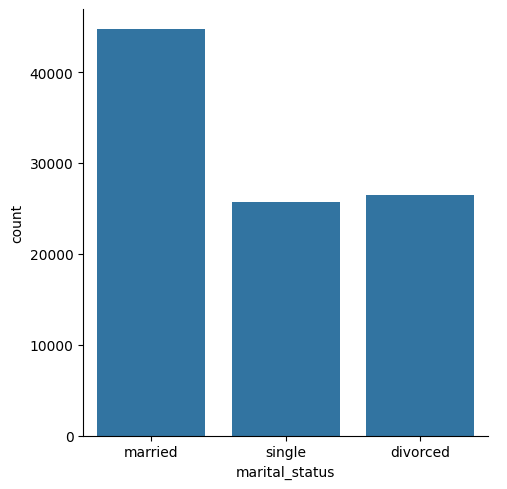

In [628]:
'counts of marital status values'
import seaborn as sns
sns.catplot(data=df, x= 'marital_status', kind= 'count')

In [629]:
# convert dtypes from object to category
# df = df.assign(**{col: df[col].astype('category') for col in df.select_dtypes(include='object')})
df.dtypes


df.location.value_counts()



location
Harare            8553
Bulawayo          8263
Mutare            8262
Gweru             7983
Masvingo          7665
Marondera         7513
Rusape            6506
Chivhu            6411
Plumtree          5552
Beitbridge        5311
Chipinge          4447
Chimanimani       4388
Kwekwe            3491
Chiredzi          3199
Kadoma            3118
Nyanga            2142
Karoi             1899
Shurugwi          1359
Zvishavane        1301
Gokwe              920
Kariba             671
Victoria Falls     219
Redcliff           191
Hwange              41
Name: count, dtype: int64

In [630]:
df.isna().sum()

gender                     0
disbursemet_date           0
currency                   0
country                    0
sex                        0
is_employed                0
job                     4136
location                 595
loan_amount                0
number_of_defaults         0
outstanding_balance        0
interest_rate              0
age                        0
number_of_defaults.1       0
remaining term             0
salary                     0
marital_status          3127
age.1                      0
Loan Status                0
dtype: int64

In [631]:
df[df.marital_status.isna()]

,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
43,male,2023 10 12,USD,zimbabwe,male,True,Accountant,Nyanga,53000.0,0,47908.382308,0.22,43,0,66,4029.182109,None,43,Did not default
46,male,2022 09 07,USD,zimbabwe,male,True,Nurse,Rusape,21000.0,2,32010.804079,0.21,46,2,41,2172.367370,None,46,Did not default
56,female,2020 09 07,USD,zimbabwe,female,True,Teacher,Marondera,40000.0,2,31575.202717,0.22,40,2,56,3502.570364,None,40,Did not default
164,other,2021 08 07,USD,zimbabwe,other,True,Nurse,Harare,35000.0,0,35203.459313,0.21,45,0,77,3965.866597,None,45,Did not default
201,male,2020 06 26,USD,zimbabwe,male,True,Software Developer,Chiredzi,26000.0,0,29219.996988,0.22,44,0,44,2462.567968,None,44,Did not default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99860,male,2022 12 14,USD,zimbabwe,male,True,Nurse,Harare,26000.0,0,33869.045205,0.22,49,0,34,1966.933126,None,49,Did not default
99905,male,2021 04 06,USD,zimbabwe,male,True,Doctor,Mutare,30000.0,0,43916.108935,0.22,46,0,40,2279.161532,None,46,Did not default
99975,male,2021 05 26,USD,zimbabwe,male,True,Doctor,Chipinge,17000.0,0,29222.426824,0.22,41,0,47,2271.360413,None,41,Did not default
99979,other,2021 08 17,USD,zimbabwe,other,True,Data Analyst,Mutare,33000.0,0,36943.492191,0.20,46,0,68,3318.342155,None,46,Did not default


In [632]:
df.marital_status.unique()

array(['married', 'single', 'divorced', None], dtype=object)

In [633]:
# import importlib
# import predict_marital
# importlib.reload(predict_marital)
# from predict_marital import Predict_ML





# mdl = Predict_ML(df)
# mdl.train()




In [634]:
# status =[]

# for i in mdl.predict(): 
#     if i == 0:
#         status.append('single')
#     elif i ==1:
#         status.append('married')
#     elif i ==2:
#         status.append('divorced')
          
# df.loc[df.marital_status.isna(), 'marital_status' ] = status  
# df     

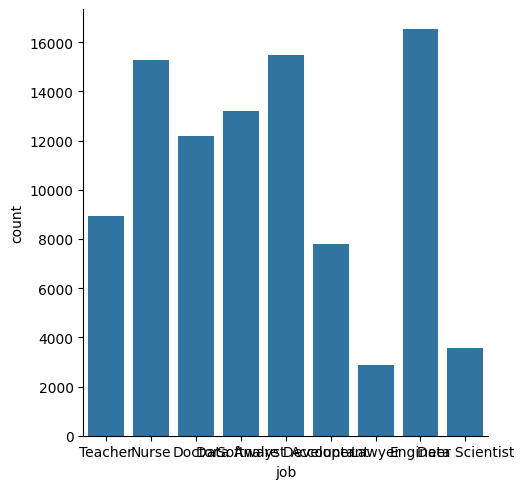

In [635]:
df.job.value_counts()
sns.catplot(data=df, x='job', kind= 'count')

In [636]:
# df.loc[:, [ col for col in df if df[col].dtype not in ['object', 'boolean'] ] + ['job']].groupby('job').size()
df['job'].unique()
df

,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,female,2022 10 29,USD,zimbabwe,female,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,other,2020 06 06,USD,zimbabwe,other,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,other,2023 09 29,USD,zimbabwe,other,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,female,2022 06 22,USD,zimbabwe,female,True,Doctor,Rusape,24000.0,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default
4,male,2023 02 08,USD,zimbabwe,male,True,Nurse,Chipinge,19000.0,0,34156.055882,0.20,42,0,45,2310.858441,married,42,Did not default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,male,2021 10 20,USD,zimbabwe,male,False,NaN,Marondera,36000.0,1,32968.219881,0.21,52,1,29,1803.818844,single,52,Did not default
99996,other,2023 06 11,USD,zimbabwe,other,True,Engineer,Chimanimani,43000.0,0,48652.554897,0.23,50,0,57,3056.127917,married,50,Did not default
99997,female,2021 10 20,USD,zimbabwe,female,True,Data Analyst,Kadoma,48000.0,0,34266.224130,0.23,43,0,53,3535.599759,married,43,Did not default
99998,male,2021 08 22,USD,zimbabwe,male,True,Engineer,Mutare,36000.0,2,71546.024917,0.22,49,2,59,3082.407123,single,49,Did not default


In [637]:
# import importlib
# import predict_marital
# importlib.reload(predict_marital)
# from predict_marital import Predict_Job

# mdl1 = Predict_Job(df)
# mdl1.train()
# df

In [638]:
# mapping = {0: 'Teacher', 1:'Nurse', 2:'Doctor', 3:'Data Analyst', 4:'Software Developer',
#        5:'Accountant',6: 'Lawyer',7: 'Engineer',8:'Data Scientist'}

# status = []

# for i in mdl1.predict():
#     status.append(mapping[i])

# df.loc[df.job.isna(), 'job'] = status    
df.dropna(axis=0)


,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,female,2022 10 29,USD,zimbabwe,female,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,other,2020 06 06,USD,zimbabwe,other,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,other,2023 09 29,USD,zimbabwe,other,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,female,2022 06 22,USD,zimbabwe,female,True,Doctor,Rusape,24000.0,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default
4,male,2023 02 08,USD,zimbabwe,male,True,Nurse,Chipinge,19000.0,0,34156.055882,0.20,42,0,45,2310.858441,married,42,Did not default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,male,2020 01 12,USD,zimbabwe,male,True,Teacher,Beitbridge,52000.0,0,44720.871567,0.21,41,0,33,2048.664042,married,41,Did not default
99996,other,2023 06 11,USD,zimbabwe,other,True,Engineer,Chimanimani,43000.0,0,48652.554897,0.23,50,0,57,3056.127917,married,50,Did not default
99997,female,2021 10 20,USD,zimbabwe,female,True,Data Analyst,Kadoma,48000.0,0,34266.224130,0.23,43,0,53,3535.599759,married,43,Did not default
99998,male,2021 08 22,USD,zimbabwe,male,True,Engineer,Mutare,36000.0,2,71546.024917,0.22,49,2,59,3082.407123,single,49,Did not default


In [639]:

df

,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,female,2022 10 29,USD,zimbabwe,female,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,other,2020 06 06,USD,zimbabwe,other,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,other,2023 09 29,USD,zimbabwe,other,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,female,2022 06 22,USD,zimbabwe,female,True,Doctor,Rusape,24000.0,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default
4,male,2023 02 08,USD,zimbabwe,male,True,Nurse,Chipinge,19000.0,0,34156.055882,0.20,42,0,45,2310.858441,married,42,Did not default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,male,2021 10 20,USD,zimbabwe,male,False,NaN,Marondera,36000.0,1,32968.219881,0.21,52,1,29,1803.818844,single,52,Did not default
99996,other,2023 06 11,USD,zimbabwe,other,True,Engineer,Chimanimani,43000.0,0,48652.554897,0.23,50,0,57,3056.127917,married,50,Did not default
99997,female,2021 10 20,USD,zimbabwe,female,True,Data Analyst,Kadoma,48000.0,0,34266.224130,0.23,43,0,53,3535.599759,married,43,Did not default
99998,male,2021 08 22,USD,zimbabwe,male,True,Engineer,Mutare,36000.0,2,71546.024917,0.22,49,2,59,3082.407123,single,49,Did not default


In [640]:
df.dropna(axis = 0, inplace = True)
df.isna().sum()

gender                  0
disbursemet_date        0
currency                0
country                 0
sex                     0
is_employed             0
job                     0
location                0
loan_amount             0
number_of_defaults      0
outstanding_balance     0
interest_rate           0
age                     0
number_of_defaults.1    0
remaining term          0
salary                  0
marital_status          0
age.1                   0
Loan Status             0
dtype: int64

# EXPLORATORY DATA ANALYSIS

In [641]:
#spread of data using quantiles
df.loc[:, [col for col in df if df[col].dtype not in ['object', 'bool']]].quantile(np.arange(0,1.1,0.1))

for i in df.columns:
    if df[i].dtype == 'float64' or df[i].dtype == 'int64':
        
        low_quart, high_quart = df[i].quantile(0.25), df[i].quantile(0.75)
        inter_quart_range = 1.5 * (high_quart -low_quart)
        low_out, high_out = low_quart-inter_quart_range, high_quart+ inter_quart_range

        df = df.loc[(df[i]> low_out) & (df[i]< high_out)]

df      

,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,female,2022 10 29,USD,zimbabwe,female,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,other,2020 06 06,USD,zimbabwe,other,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,other,2023 09 29,USD,zimbabwe,other,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,female,2022 06 22,USD,zimbabwe,female,True,Doctor,Rusape,24000.0,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default
4,male,2023 02 08,USD,zimbabwe,male,True,Nurse,Chipinge,19000.0,0,34156.055882,0.20,42,0,45,2310.858441,married,42,Did not default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,female,2022 01 22,USD,zimbabwe,female,True,Doctor,Masvingo,5000.0,0,23808.419493,0.22,55,0,33,1855.901970,single,55,Did not default
99994,male,2020 01 12,USD,zimbabwe,male,True,Teacher,Beitbridge,52000.0,0,44720.871567,0.21,41,0,33,2048.664042,married,41,Did not default
99996,other,2023 06 11,USD,zimbabwe,other,True,Engineer,Chimanimani,43000.0,0,48652.554897,0.23,50,0,57,3056.127917,married,50,Did not default
99997,female,2021 10 20,USD,zimbabwe,female,True,Data Analyst,Kadoma,48000.0,0,34266.224130,0.23,43,0,53,3535.599759,married,43,Did not default


<Figure size 1200x800 with 0 Axes>

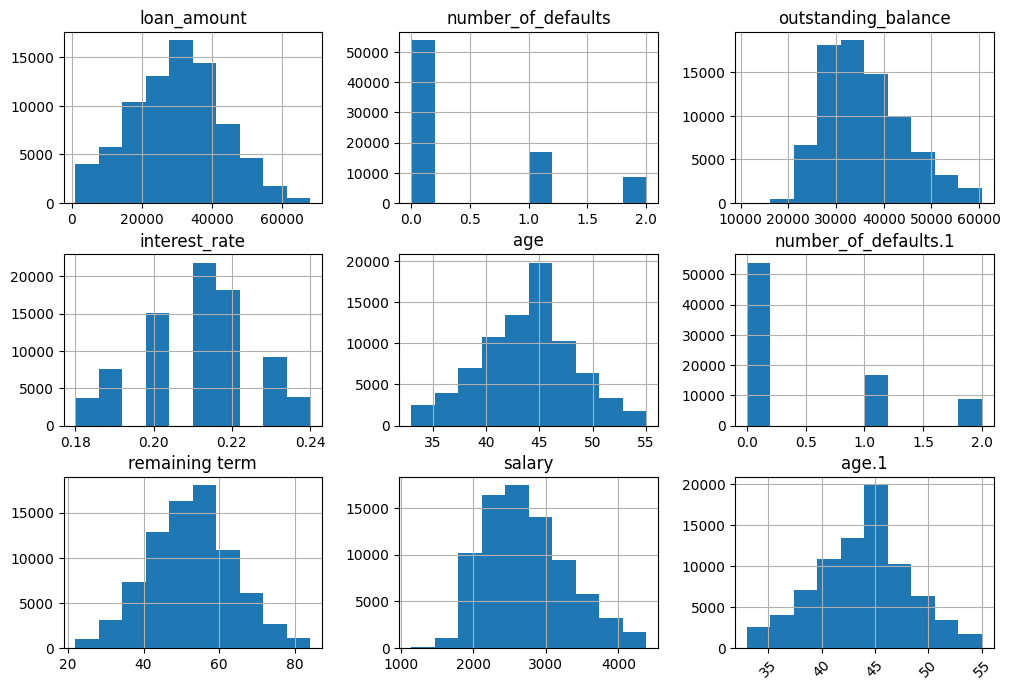

In [642]:
#distribution of features

plt.figure(figsize = (12,8))
df.hist(figsize = (12,8));
plt.xticks(rotation = 45);

In [643]:
#convert to object dtypes to category for faster computation  
df = df.assign(**{col: df[col].astype('category') for col in df.select_dtypes(include='object')})

In [644]:
#multivariate relationship

# import seaborn as sns
# sns.pairplot(df)

<Axes: >

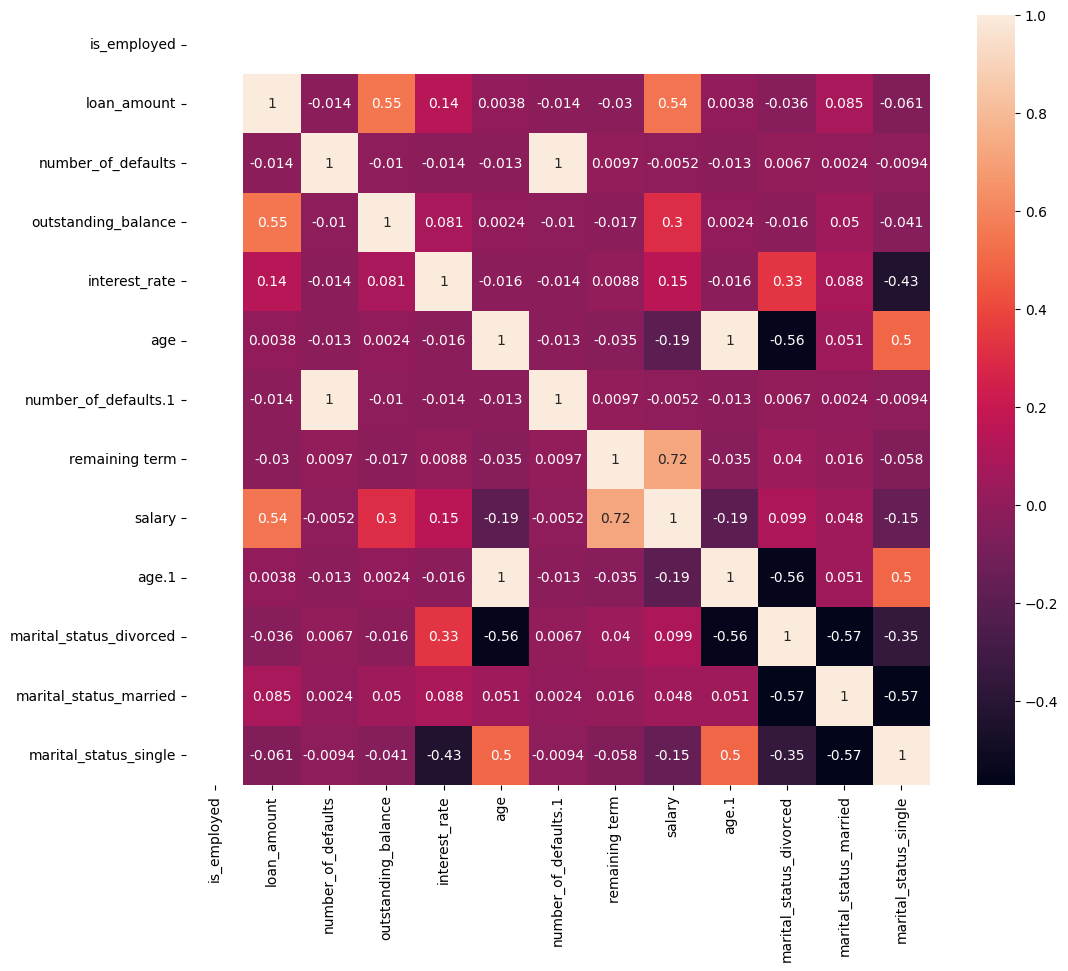

In [645]:
#multivariate relationships 
from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# le.fit(['Did not default', 'Defaulted'])
# df['Loan Status'] = le.transform(df['Loan Status'])

# marital = df.marital_status.map({'single': 0, 'married':1, 'divorced': 2})
plt.figure(figsize=(12,10))
df_encoded = pd.get_dummies(df, columns=['marital_status'])
df_encoded

corrData = df_encoded.loc[:, [col for col in df_encoded if df_encoded[col].dtype not in ['category', 'object']]]

sns.heatmap(corrData.corr(), annot= True)



In [646]:
# loan_utilization_ratio = df['outstanding_balance']/ df['loan_amount']
# df = df.drop(['loan_amount', 'outstanding_balance'], axis=1)
# df['loan_utilization_ratio'] = np.log(loan_utilization_ratio +0.1) 

# df.hist()
# df

In [647]:
# drop redundant features
df.drop(['currency', 'country'], axis=1, inplace=True)


In [648]:
df.marital_status.value_counts()

marital_status
married     38131
single      20704
divorced    20614
Name: count, dtype: int64

In [649]:
df

,gender,disbursemet_date,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,female,2022 10 29,female,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,other,2020 06 06,other,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,other,2023 09 29,other,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,female,2022 06 22,female,True,Doctor,Rusape,24000.0,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default
4,male,2023 02 08,male,True,Nurse,Chipinge,19000.0,0,34156.055882,0.20,42,0,45,2310.858441,married,42,Did not default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,female,2022 01 22,female,True,Doctor,Masvingo,5000.0,0,23808.419493,0.22,55,0,33,1855.901970,single,55,Did not default
99994,male,2020 01 12,male,True,Teacher,Beitbridge,52000.0,0,44720.871567,0.21,41,0,33,2048.664042,married,41,Did not default
99996,other,2023 06 11,other,True,Engineer,Chimanimani,43000.0,0,48652.554897,0.23,50,0,57,3056.127917,married,50,Did not default
99997,female,2021 10 20,female,True,Data Analyst,Kadoma,48000.0,0,34266.224130,0.23,43,0,53,3535.599759,married,43,Did not default


In [650]:
#remove duplicated column
df.drop(['age.1', 'number_of_defaults.1'], axis=1, inplace= True)


In [651]:
df.drop('sex', axis=1, inplace=True)
df

,gender,disbursemet_date,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status,Loan Status
0,female,2022 10 29,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,47,3230.038869,married,Did not default
1,other,2020 06 06,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,62,3194.139103,single,Did not default
2,other,2023 09 29,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,57,3330.826656,married,Did not default
3,female,2022 06 22,True,Doctor,Rusape,24000.0,0,35681.496413,0.23,47,42,2246.797020,divorced,Did not default
4,male,2023 02 08,True,Nurse,Chipinge,19000.0,0,34156.055882,0.20,42,45,2310.858441,married,Did not default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,female,2022 01 22,True,Doctor,Masvingo,5000.0,0,23808.419493,0.22,55,33,1855.901970,single,Did not default
99994,male,2020 01 12,True,Teacher,Beitbridge,52000.0,0,44720.871567,0.21,41,33,2048.664042,married,Did not default
99996,other,2023 06 11,True,Engineer,Chimanimani,43000.0,0,48652.554897,0.23,50,57,3056.127917,married,Did not default
99997,female,2021 10 20,True,Data Analyst,Kadoma,48000.0,0,34266.224130,0.23,43,53,3535.599759,married,Did not default


In [652]:
df['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format= '%Y %m %d')
from sklearn.utils import shuffle



In [653]:

X = df.drop('Loan Status', axis = 1)
y = df['Loan Status']




In [654]:
df = df[df.gender == 'other']
df

,gender,disbursemet_date,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status,Loan Status
1,other,2020-06-06,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,62,3194.139103,single,Did not default
2,other,2023-09-29,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,57,3330.826656,married,Did not default
5,other,2020-11-15,True,Data Analyst,Chimanimani,29000.0,0,37778.075179,0.21,46,44,2633.653709,single,Did not default
8,other,2020-04-04,True,Nurse,Kadoma,23000.0,0,28015.543801,0.22,46,47,2521.387875,married,Did not default
12,other,2023-12-17,True,Software Developer,Gweru,40000.0,1,45041.416735,0.22,46,49,2724.932302,married,Did not default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99986,other,2023-03-11,True,Software Developer,Harare,28000.0,0,42432.805478,0.22,43,39,2201.575745,married,Did not default
99990,other,2023-05-22,True,Software Developer,Chivhu,39000.0,0,36199.781666,0.22,44,81,4328.835496,divorced,Did not default
99991,other,2022-04-23,True,Nurse,Beitbridge,24000.0,0,36404.685429,0.23,45,48,2540.043310,married,Did not default
99996,other,2023-06-11,True,Engineer,Chimanimani,43000.0,0,48652.554897,0.23,50,57,3056.127917,married,Did not default


In [655]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
X1 = X.drop([ 'disbursemet_date', 'is_employed'], axis=1)

X_transformed = pd.get_dummies(X1, columns=['marital_status', 'gender' ,'job', 'location'])

# one_hot = OneHotEncoder()
# categories = ['gender','location', 'job','marital_status']
# transformer = ColumnTransformer([('one_hot', one_hot, categories)])
# X_transformed = transformer.fit_transform(X)
X_transformed
# X_transformed.drop(['disbursemet_date', 'location'], axis=1, inplace=True)

features = X_transformed.columns
X_transformed


,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status_divorced,marital_status_married,marital_status_single,gender_female,gender_male,gender_other,job_Accountant,job_Data Analyst,job_Data Scientist,job_Doctor,job_Engineer,job_Lawyer,job_Nurse,job_Software Developer,job_Teacher,location_Beitbridge,location_Bulawayo,location_Chimanimani,location_Chipinge,location_Chiredzi,location_Chivhu,location_Gokwe,location_Gweru,location_Harare,location_Hwange,location_Kadoma,location_Kariba,location_Karoi,location_Kwekwe,location_Marondera,location_Masvingo,location_Mutare,location_Nyanga,location_Plumtree,location_Redcliff,location_Rusape,location_Shurugwi,location_Victoria Falls,location_Zvishavane
0,39000.0,0,48653.011473,0.22,37,47,3230.038869,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,27000.0,2,28752.062237,0.20,43,62,3194.139103,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,35000.0,1,44797.554126,0.22,43,57,3330.826656,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,24000.0,0,35681.496413,0.23,47,42,2246.797020,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,19000.0,0,34156.055882,0.20,42,45,2310.858441,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,5000.0,0,23808.419493,0.22,55,33,1855.901970,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
99994,52000.0,0,44720.871567,0.21,41,33,2048.664042,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
99996,43000.0,0,48652.554897,0.23,50,57,3056.127917,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
99997,48000.0,0,34266.224130,0.23,43,53,3535.599759,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [656]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=25, whiten= True, svd_solver='arpack').fit(X_transformed)
# pca.explained_variance_ratio_.sum()
# x_pca = pca.transform(X_transformed)
from sklearn.preprocessing import LabelEncoder

y1 = y.map({'Did not default': 0, 'Defaulted': 1})

print(y.value_counts())
print(pd.DataFrame(y1).value_counts())


Loan Status
Did not default    69948
Defaulted           9501
Name: count, dtype: int64
Loan Status
0              69948
1               9501
Name: count, dtype: int64


In [657]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)
y_resampled
y_resampled = y_resampled.map({'Did not default': 0, 'Defaulted': 1})

In [658]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(X_transformed)
clf = RandomForestClassifier(n_jobs=-1)
from sklearn.ensemble import AdaBoostClassifier

xgboost = xgb.XGBClassifier()

result = cross_val_score(RandomForestClassifier(n_jobs=-1),X =X_resampled, y= y_resampled, cv= KFold(n_splits=5, shuffle=True) )

print(result)



[0.96054325 0.96136388 0.96150684 0.96100647 0.96150684]


In [659]:
result.mean()

0.9611854566407294

In [660]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, classification_report
clf = RandomForestClassifier(n_jobs=-1)

X = X_resampled.to_numpy()
y = y_resampled.to_numpy()

kf = KFold(n_splits=5)
fold_index = 0

for train_index, test_index in kf.split(X):
    print(f"Fold {fold_index + 1}:")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

    clf.fit(X_train,y_train)
    print(f"score: {clf.score(X_test,y_test)}")
    print("=================")
    print()
    
    fold_index += 1


Fold 1:
Train indices: [ 27980  27981  27982 ... 139893 139894 139895]
Test indices: [    0     1     2 ... 27977 27978 27979]
score: 0.9321300929235168

Fold 2:
Train indices: [     0      1      2 ... 139893 139894 139895]
Test indices: [27980 27981 27982 ... 55956 55957 55958]
score: 0.9305193180599736

Fold 3:
Train indices: [     0      1      2 ... 139893 139894 139895]
Test indices: [55959 55960 55961 ... 83935 83936 83937]
score: 0.9433861110118303

Fold 4:
Train indices: [     0      1      2 ... 139893 139894 139895]
Test indices: [ 83938  83939  83940 ... 111914 111915 111916]
score: 0.9979984988741556

Fold 5:
Train indices: [     0      1      2 ... 111914 111915 111916]
Test indices: [111917 111918 111919 ... 139893 139894 139895]
score: 0.9986060974302156



In [661]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, classification_report
clf = RandomForestClassifier(n_jobs=-1)


X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2)

clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)

print(classification_report(y_test,y_preds))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96     14104
           1       0.98      0.93      0.96     13876

    accuracy                           0.96     27980
   macro avg       0.96      0.96      0.96     27980
weighted avg       0.96      0.96      0.96     27980



In [662]:
features1 = pd.DataFrame(clf.feature_importances_).T
features1.columns = features
features1


,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status_divorced,marital_status_married,marital_status_single,gender_female,gender_male,gender_other,job_Accountant,job_Data Analyst,job_Data Scientist,job_Doctor,job_Engineer,job_Lawyer,job_Nurse,job_Software Developer,job_Teacher,location_Beitbridge,location_Bulawayo,location_Chimanimani,location_Chipinge,location_Chiredzi,location_Chivhu,location_Gokwe,location_Gweru,location_Harare,location_Hwange,location_Kadoma,location_Kariba,location_Karoi,location_Kwekwe,location_Marondera,location_Masvingo,location_Mutare,location_Nyanga,location_Plumtree,location_Redcliff,location_Rusape,location_Shurugwi,location_Victoria Falls,location_Zvishavane
0,0.059056,0.009106,0.035833,0.116707,0.045716,0.027328,0.035493,0.057388,0.064839,0.038828,0.037521,0.040145,0.041311,0.008647,0.022313,0.01288,0.010813,0.018664,0.003427,0.01982,0.014424,0.021394,0.001734,0.003823,0.001479,0.016916,0.054279,0.002242,0.02726,0.003141,0.004468,0.000657,0.001076,0.000303,0.037643,0.028259,0.002508,0.006129,0.004784,0.000784,0.013807,0.000152,0.008106,0.033906,0.004449,0.000443


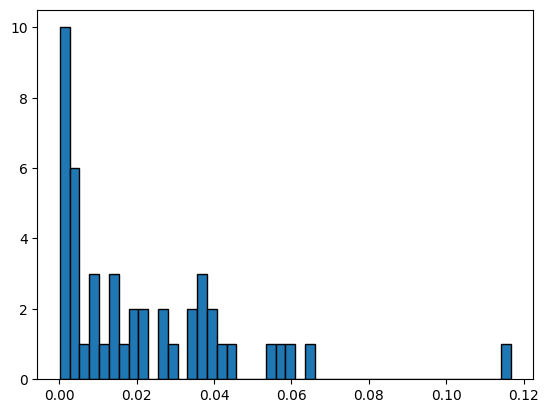

In [663]:
plt.hist(clf.feature_importances_, bins=len(clf.feature_importances_), edgecolor='k');

gender
job
location
marital_status
Loan Status


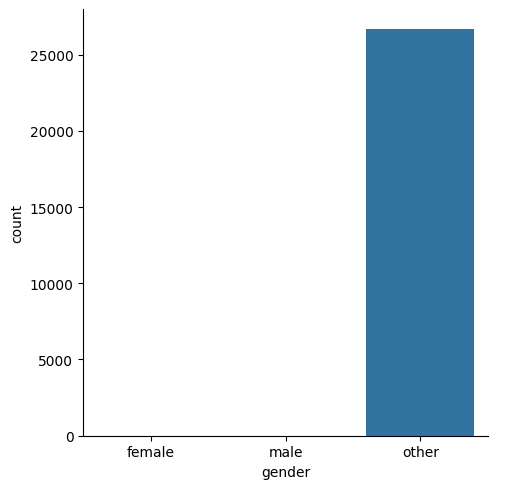

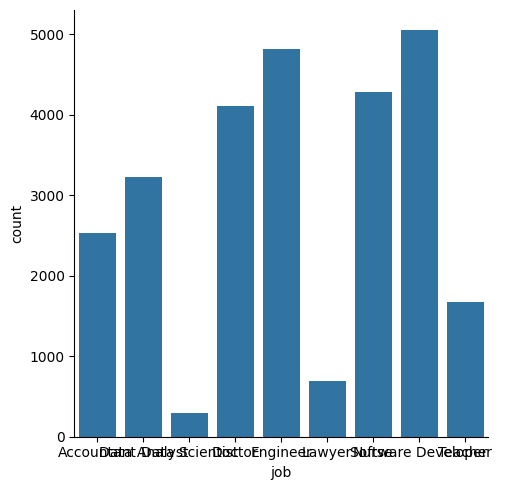

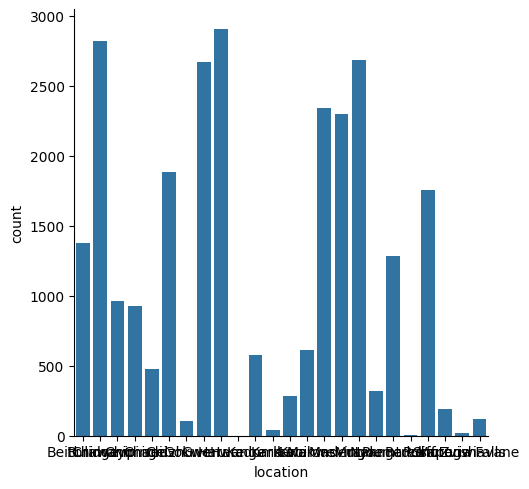

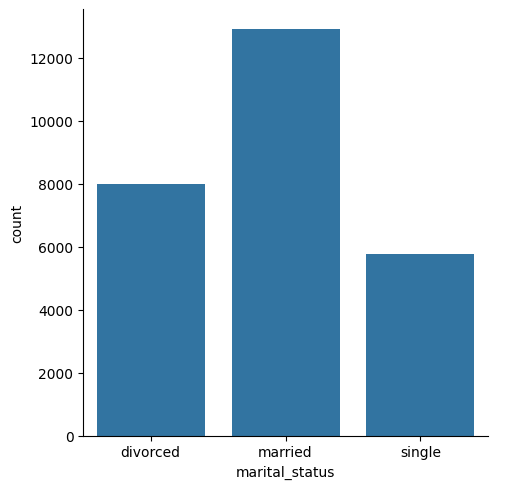

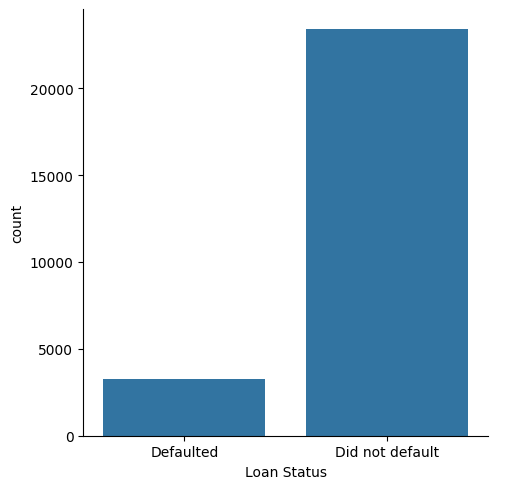

In [664]:
for i in df.loc[:, df.dtypes == 'category']:
    print(i)
    sns.catplot(data= df, x=i, kind='count')



In [665]:
clf.feature_importances_

array([0.05905591, 0.00910624, 0.03583325, 0.11670686, 0.04571606,
       0.02732797, 0.03549298, 0.05738838, 0.06483886, 0.03882767,
       0.03752141, 0.04014497, 0.04131052, 0.00864662, 0.02231318,
       0.01287957, 0.0108126 , 0.01866367, 0.00342658, 0.01982026,
       0.01442384, 0.02139361, 0.00173378, 0.00382322, 0.00147944,
       0.01691641, 0.05427866, 0.00224199, 0.02726024, 0.00314136,
       0.00446808, 0.00065728, 0.00107595, 0.00030261, 0.03764327,
       0.02825877, 0.00250772, 0.00612854, 0.004784  , 0.00078374,
       0.0138074 , 0.00015224, 0.00810568, 0.03390624, 0.00444937,
       0.00044302])